# ML mini project
## Classification task on the Cifar10 color image dataset using a CNN

## Setup

In [1]:
import sys
import os
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


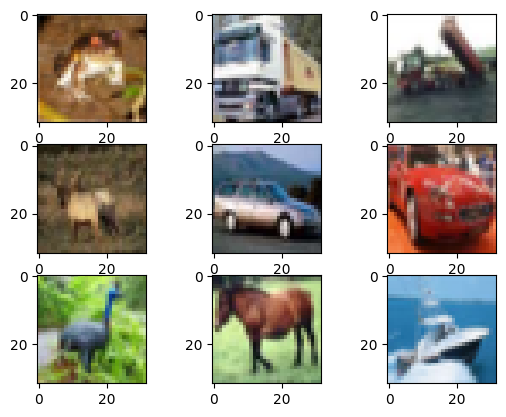

In [2]:


# load dataset
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train_full.shape, y_train_full.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
# plot first few images
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train_full[i])
# show the figure
plt.show()

In [3]:
# Split the full training set into a validation set and a (smaller) training set,
# and scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

In [4]:
X_valid.dtype

dtype('float64')

In [5]:
y_train

array([[6],
       [7],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [6]:
print('Validation: X=%s, y=%s' % (X_valid.shape, y_valid.shape))
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))

Validation: X=(5000, 32, 32, 3), y=(5000, 1)
Train: X=(45000, 32, 32, 3), y=(45000, 1)


In [7]:
class_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]

In [8]:
y_train.shape

(45000, 1)

## BuildModel method

In [9]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

In [10]:
from scikeras.wrappers import KerasClassifier, KerasRegressor
from typing import Dict, Iterable, Any

In [11]:
def build_and_compile_model(startingFilters = 32, n_layers = 1 ):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same", 
                        input_shape=[32, 32, 3]))
    model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
    model.add(keras.layers.MaxPooling2D(pool_size=2))
    if(n_layers > 1):
        for layer in range(n_layers - 1):
            startingFilters *= 2
            model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
            model.add(keras.layers.Conv2D(startingFilters, kernel_size=3, activation='relu', padding="same"))
            model.add(keras.layers.MaxPooling2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(units=64, activation='relu'))
    model.add( keras.layers.Dropout(0.5))
    model.add( keras.layers.Dense(units=10, activation='softmax'))

# You must at least specify the loss function and the optimizer to use. 
# You can also specify a list of additional metrics to use during training and evaluation.
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(momentum=0.9),
              metrics=["accuracy"])

    return model

    




## HyperParameter tunning
"VGG is a classical convolutional neural network architecture. It was based on an analysis of how to increase the depth of such networks. The network utilises small 3 x 3 filters. Otherwise the network is characterized by its simplicity: the only other components being pooling layers and a fully connected layer."
https://paperswithcode.com/method/vgg last visited 09/12/2022

### Tune the model

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# Define hyperparameter sets and ranges to explore
param_distribs = {
    "startingFilters": [ 32, 64, 128],
    "n_layers": [ 1, 2, 3]
}
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

keras_classifier = KerasClassifier(build_and_compile_model, startingFilters=param_distribs["startingFilters"], n_layers=param_distribs["n_layers"])

rand_search_cv = RandomizedSearchCV(keras_classifier, param_distribs, n_jobs=1, cv=4, n_iter= 4)
# Search
rand_search_cv.fit(X_train, y_train, epochs=20,
                  validation_data=(X_valid, y_valid),
                  callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
1055/1055 [==============================] - 8s 7ms/step - loss: 2.0928 - accuracy: 0.2065 - val_loss: 1.8166 - val_accuracy: 0.2982
Epoch 2/50
1055/1055 [==============================] - 7s 6ms/step - loss: 1.7803 - accuracy: 0.3327 - val_loss: 1.5293 - val_accuracy: 0.4448
Epoch 3/50
1055/1055 [==============================] - 7s 7ms/step - loss: 1.6190 - accuracy: 0.4092 - val_loss: 1.4270 - val_accuracy: 0.4940
Epoch 4/50
1055/1055 [==============================] - 7s 7ms/step - loss: 1.5030 - accuracy: 0.4544 - val_loss: 1.2866 - val_accuracy: 0.5426
Epoch 5/50
1055/1055 [==============================] - 7s 7ms/step - loss: 1.4197 - accuracy: 0.4889 - val_loss: 1.2964 - val_accuracy: 0.5534
Epoch 6/50
1055/1055 [==============================] - 7s 6ms/step - loss: 1.3478 - accuracy: 0.5160 - val_loss: 1.2011 - val_accuracy: 0.5678
Epoch 7/50
1055/1055 [==============================] - 7s 7ms/step - loss: 1.2713 - accuracy: 0.5462 - val_loss: 1.1494 - val_accuracy:

KeyboardInterrupt: 

In [16]:
rand_search_cv.best_params_



{'startingFilters': 128, 'n_layers': 2}

In [21]:
rand_search_cv.best_estimator_

NameError: name 'rand_search_cv' is not defined

We ran rand_search_cv to get the best starting number of filters and number of layers and got this result: {'startingFilters': 128, 'n_layers': 2}

## Create a CNN With with the hyperparameters found through tuning with more epochs

In [16]:
model = build_and_compile_model(startingFilters=128, n_layers=2)

### Show information about the model

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 128)       3584      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 256)       590080    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 256)        0         
 2D)                                                  

### Train the model

In [18]:
# EarlyStopping (with rollback to the best model).
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Performance scheduling
# (multiply the learning rate by a factor when the error stops dropping for a number of epochs, called patience)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4)

history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/50
1407/1407 [==============================] - 36s 25ms/step - loss: 2.0363 - accuracy: 0.2317 - val_loss: 1.6168 - val_accuracy: 0.4146 - lr: 0.0100
Epoch 2/50
1407/1407 [==============================] - 50s 36ms/step - loss: 1.6112 - accuracy: 0.4037 - val_loss: 1.2985 - val_accuracy: 0.5336 - lr: 0.0100
Epoch 3/50
1407/1407 [==============================] - 56s 40ms/step - loss: 1.3525 - accuracy: 0.5154 - val_loss: 1.0685 - val_accuracy: 0.6248 - lr: 0.0100
Epoch 4/50
1407/1407 [==============================] - 49s 35ms/step - loss: 1.1780 - accuracy: 0.5907 - val_loss: 0.9389 - val_accuracy: 0.6814 - lr: 0.0100
Epoch 5/50
1407/1407 [==============================] - 52s 37ms/step - loss: 1.0350 - accuracy: 0.6440 - val_loss: 0.8749 - val_accuracy: 0.7004 - lr: 0.0100
Epoch 6/50
1407/1407 [==============================] - 46s 33ms/step - loss: 0.9377 - accuracy: 0.6837 - val_loss: 0.9191 - val_accuracy: 0.6922 - lr: 0.0100
Epoch 7/50
1407/1407 [========================

Because of early stopping the training concluded at 11 epochs

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

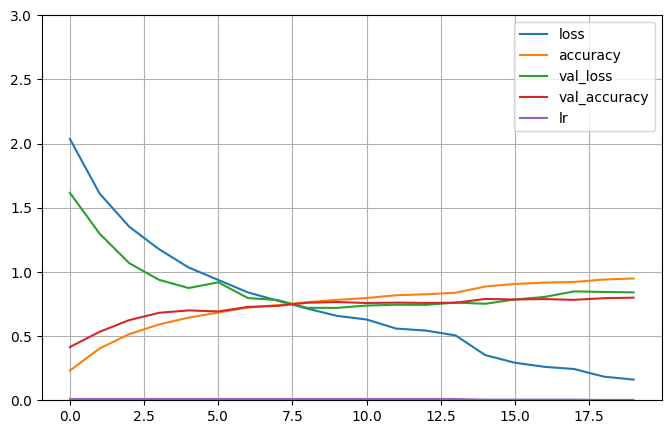

In [20]:
# Show the learning curves.
# (The training curves should be shifted half an epoch to the left to be completely comparable with
# the validation curves).

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 3)
plt.show()

## Training curve for the final_model
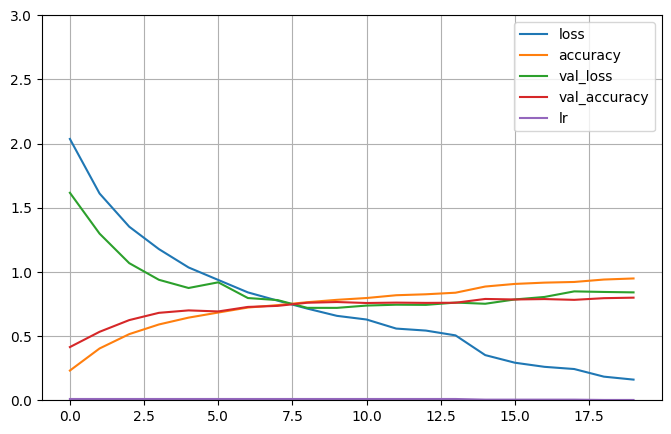

### Evaluate the model

In [21]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.7437 - accuracy: 0.7601


[0.7436864972114563, 0.7601000070571899]

The model ended up with 
loss: 0.8993 - accuracy: 0.7652

### Save the model

In [20]:
# save model
model.save('final_model')

INFO:tensorflow:Assets written to: final_model\assets


INFO:tensorflow:Assets written to: final_model\assets


## Load the final model and evaluate on the test set and a new image

### Load Image

In [23]:
from keras.utils import load_img
from keras.utils import img_to_array

In [24]:
def load_image(filename):
 # load the image
 img = load_img(filename, target_size=(32, 32))
 # convert to array
 img = img_to_array(img)
 # reshape into a single sample with 3 channels
 img = img.reshape(1, 32, 32, 3)
 # prepare pixel data
 img = img.astype('float32')
 img = img / 255.0
 return img

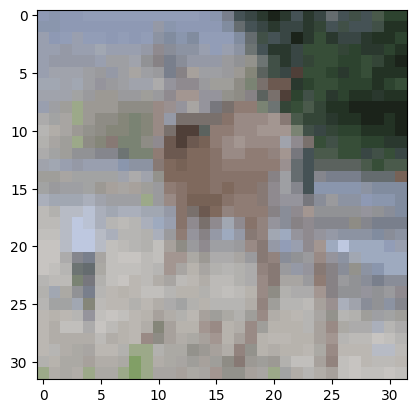

In [30]:
test_img = load_image('Test_Images\deer_image.webp')

plt.imshow(test_img[0])


### Load model and test it

In [32]:
from keras.models import load_model

final_model = load_model('saved_models/final_model')

final_model.evaluate(X_test,y_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.8993 - accuracy: 0.7652


[0.8992981314659119, 0.7652000188827515]

In [47]:
result = final_model.predict(test_img)

result.round(2)

1/1 [==============================] - 0s 19ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.61, 0.03, 0.  , 0.36, 0.  , 0.  ]],
      dtype=float32)

In [48]:
result = final_model.predict(test_img)

classes=np.argmax(result,axis=1)

class_names[classes[0]] 


1/1 [==============================] - 0s 19ms/step


'deer'